Possible datasets
 - https://data.world/crowdflower/apple-twitter-sentiment
 - https://paperswithcode.com/dataset/stocknet-1
 - https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction
 - https://www.kaggle.com/datasets/thedevastator/tweet-sentiment-s-impact-on-stock-returns
 - https://ieee-dataport.org/open-access/stock-market-tweets-data
 - https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset
 - https://www.kaggle.com/datasets/kazanova/sentiment140
 - https://www.kaggle.com/datasets/sixlack/finaldf (using)
 - https://www.kaggle.com/datasets/utkarshxy/stock-markettweets-lexicon-data (using)
 - https://www.kaggle.com/datasets/sidarcidiacono/news-sentiment-analysis-for-stock-data-by-company/data (using)
 - https://ieee-dataport.org/open-access/stock-market-tweets-data (not good)
 - https://redu.unicamp.br/dataset.xhtml?persistentId=doi:10.25824/redu/GFJHFK (not good)

In [ ]:
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from multiprocessing import Pool
import multiprocessing

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from gensim.models import Word2Vec
from torchtext.data import get_tokenizer
import torchtext
import fasttext

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
# import kaggle

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199771 sha256=ed89fd0059bd98c744a6501b5d92f360e59f15a0969ac4e2e1c4e20350491c05
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


## Loading:

In [ ]:
new_directory = "/content/sample_data/"
os.chdir(new_directory)

In [ ]:
RANDOM_STATE = 2023
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
SEQUENCE_LENGTH = 300
CURRENT_DIRECTORY = os.getcwd()
W2V_SIZE = 300
NUM_CORE = multiprocessing.cpu_count()
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10


In [ ]:
DATASETS = [
    {
        'name': "training.1600000.processed.noemoticon.csv",
        'api': "kazanova/sentiment140",
        'location': "data",
        'url': "https://www.kaggle.com/datasets/kazanova/sentiment140"
    },
    {
        'name': "reddit_wsb.csv",
        'api': "gpreda/reddit-wallstreetsbets-posts",
        'location': "data",
        'url': "https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts"
    },
    {
        'name': "stock_data.csv",
        'api': "yash612/stockmarket-sentiment-dataset",
        'location': "data",
        'url': "https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset"
    },
    {
        'name': "stock_tweets.csv",
        'api': "equinxx/stock-tweets-for-sentiment-analysis-and-prediction",
        'location': "data/unorganized/Stock Tweets for Sentiment Analysis and Prediction",
        'url': "https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction"
    },
    {
        'name': "Company_Tweet.csv",
        'api': "omermetinn/tweets-about-the-top-companies-from-2015-to-2020",
        'location': "data/unorganized/Tweets about the Top Companies from 2015 to 2020",
        'url': "https://www.kaggle.com/datasets/omermetinn/tweets-about-the-top-companies-from-2015-to-2020"
    },
    {
        'name': "stockerbot-export.csv",
        'api': "davidwallach/financial-tweets",
        'location': "data/unorganized/Financial Tweets",
        'url': "https://www.kaggle.com/datasets/davidwallach/financial-tweets"
    }
]

for dataset_info in DATASETS:
    dataset_name = dataset_info['name']
    dataset_location = dataset_info['location']

    if not os.path.exists(os.path.join(dataset_info['location'], dataset_name)):
        print(f"Downloading {dataset_name} from {dataset_info['url']} to {dataset_location}...")
        kaggle.api.dataset_download_files(dataset_info['api'], path=dataset_location, unzip=True)


In [ ]:
dataset_filename = {
    '0': ("training.csv", ["target", "ids", "date", "flag", "user", "text"]),
    '1': ("stock_data.csv", ["text", "target"]),
    '2': ("nasdaq.csv", ["Label", "Ticker", "Headline"]), # 0 negative, 1 positive, 2 neural
    '3': ("djia_news copy.csv", ["Label", "Ticker", "Headline"]), # 0 negative, 1 positive, 2 neural
    '4': ("data-3.csv", ["Sentence", "Sentiment"]),
    '5': ("sentiment.csv", ["Stock Ticker", "Tweet Text", "Sentiment", "Tweet URL"]),
    '6': ('train_tweet.csv', ["id", "label", "tweet"])  # 0 positive, 1 negative
}

In [ ]:
dataset_path = os.path.join("", "data", dataset_filename["0"][0])
df0 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["0"][1])
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
df0.target = df0.target.apply(lambda x: decode_map[int(x)])
df0 = df0[['text', 'target']]

dataset_path = os.path.join("", "data", dataset_filename["1"][0])
df1 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["1"][1], skiprows=1)
df1.rename(columns={df1.columns[0]: 'text'}, inplace=True)
decode_map = {-1: "NEGATIVE", 1: "POSITIVE"}
df1.target = df1.target.apply(lambda x: decode_map[int(x)])

dataset_path = os.path.join("", "data", dataset_filename["2"][0])
df2 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["2"][1], skiprows=1)
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 1: "POSITIVE"}
df2['target'] = df2['Label'].apply(lambda x: decode_map[int(x)])
df2 = df2[['Headline', 'target']]
df2.rename(columns={df2.columns[0]: 'text'}, inplace=True)

dataset_path = os.path.join("", "data", dataset_filename["3"][0])
df3 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["3"][1], skiprows=1)
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 1: "POSITIVE"}
df3['target'] = df3['Label'].apply(lambda x: decode_map[int(x)])
df3 = df3[['Headline', 'target']]
df3.rename(columns={df3.columns[0]: 'text'}, inplace=True)

dataset_path = os.path.join("", "data", dataset_filename["4"][0])
df4 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["4"][1], skiprows=1)
decode_map = {"negative": "NEGATIVE", "neutral": "NEUTRAL", "positive": "POSITIVE"}
df4['target'] = df4['Sentiment'].apply(lambda x: decode_map[x])
df4.drop(columns=['Sentiment'], inplace=True)
df4.rename(columns={df4.columns[0]: 'text'}, inplace=True)

dataset_path = os.path.join("", "data", dataset_filename["5"][0])
df5 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["5"][1], skiprows=1)
decode_map = {"Negative": "NEGATIVE", "Positive": "POSITIVE"}
df5['target'] = df5['Sentiment'].apply(lambda x: decode_map[x])
df5 = df5[['Tweet Text', 'target']]
df5.rename(columns={df5.columns[0]: 'text'}, inplace=True)

dataset_path = os.path.join("", "data", dataset_filename["6"][0])
df6 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["6"][1], skiprows=1)
decode_map = {0: "POSITIVE", 1: "NEGATIVE"}
df6['target'] = df6['label'].apply(lambda x: decode_map[int(x)])
df6 = df6[['tweet', 'target']]
df6.rename(columns={df6.columns[0]: 'text'}, inplace=True)

In [ ]:
total_rows = len(df0) + len(df2) + len(df3) + len(df4) + len(df5) + len(df6)
print("Total number of rows:", total_rows)

Total number of rows: 1653866


In [ ]:
df = pd.concat([df0, df2, df3, df4, df5, df6], ignore_index=True)
df.shape

(1653866, 2)

In [ ]:
df = df[df['target'] != "NEUTRAL"]

In [ ]:
df[:-10]

,text,target
0,awww bummer shoulda got david carr third day,NEGATIVE
1,upset update facebook texting might cry result...,NEGATIVE
2,dived many times ball managed save 50 rest go ...,NEGATIVE
3,whole body feels itchy like fire,NEGATIVE
4,behaving mad see,NEGATIVE
...,...,...
1653851,user balls hashtag say weasel away lumpy tony ...,NEGATIVE
1653852,makes ask anybody god oh thank god,NEGATIVE
1653853,hear one new songs go katie ellie youtube orig...,POSITIVE
1653854,user try tail us stop butt good time goldenret...,POSITIVE


## Preprocessing:

In [ ]:
%%time
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = [word for word in text.split() if word not in stop_words]
    if stem:
        tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 39.3 s, sys: 177 ms, total: 39.5 s
Wall time: 41.8 s


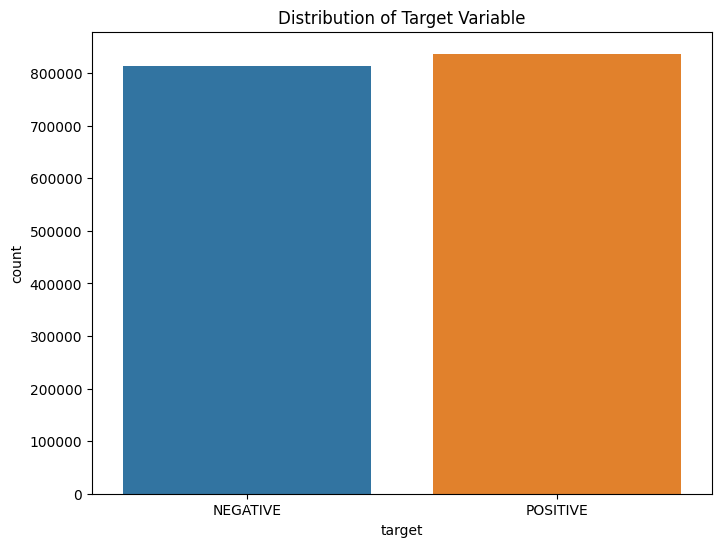

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='target')
plt.title('Distribution of Target Variable')
plt.show()

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=RANDOM_STATE)

### Fasttext and Word2vec Training: https://www.analyticsvidhya.com/blog/2023/01/introduction-to-fasttext-embeddings-and-its-implication/

In [ ]:
%%time
CURRENT_DIRECTORY = os.getcwd()
MODEL_PATH = os.path.join(CURRENT_DIRECTORY, "fasttext_model.bin")
TRAINING_DATA_PATH = os.path.join(CURRENT_DIRECTORY, "fasttext_train.txt")

if os.path.isfile(MODEL_PATH):
    fasttext_model = fasttext.load_model(MODEL_PATH)
else:
    sentences = [row.split() for row in df_train['text']]
    with open(TRAINING_DATA_PATH, "w") as f:
        for sentence in sentences:
            f.write(" ".join(sentence) + "\n")
    fasttext_model = fasttext.train_unsupervised(TRAINING_DATA_PATH, model='skipgram')
    fasttext_model.save_model(MODEL_PATH)


In [ ]:
# %%time
# MODEL_PATH = os.path.join(CURRENT_DIRECTORY, "word2vec_model.model")

# if os.path.isfile(MODEL_PATH):
#     w2v_model = Word2Vec.load(MODEL_PATH)
# else:
#     sentences = [row.split() for row in df_train['text']]
#     w2v_model = Word2Vec(sentences, vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=NUM_CORE)
#     w2v_model.build_vocab(sentences)
#     w2v_model.train(sentences, total_examples=len(documents), epochs=W2V_EPOCH)
#     w2v_model.save(MODEL_PATH)

### Tokenization:

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

### Embedding Layer:

In [ ]:
%%time
EMBEDDING_DIM = fasttext_model.get_dimension()
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_matrix[i] = fasttext_model.get_word_vector(word)

CPU times: total: 2.16 s
Wall time: 4.4 s


In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist()).reshape(-1,1)
y_test = encoder.transform(df_test.target.tolist()).reshape(-1,1)

## Preparation for PyTorch Model:

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = torch.tensor(self.texts[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return text, label

BATCH_SIZE = 128
train_dataset = TextDataset(x_train, y_train)
test_dataset = TextDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=100):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(embedding_matrix.shape[1], hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1])
        x = self.fc(x)
        x = self.sigmoid(x)
        return x.squeeze()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(embedding_matrix).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
SAVE_PATH = "model/"

# Check if multiple GPUs are available and wrap the model with DataParallel if they are
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate if needed

# Training loop
num_epochs = 6
for epoch in range(num_epochs):
    model_name = f"rnn_bs{BATCH_SIZE}_epoch{epoch+1}.pt"
    model_path = os.path.join(SAVE_PATH, model_name)

    # Check if the model for this epoch already exists
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        continue

    model.train()
    total_loss = 0
    # Wrap train_loader with tqdm for progress bar
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation loop for accuracy after training
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = torch.round(outputs)
            correct_preds += (preds == y.squeeze()).sum().item()
            total_preds += y.size(0)
    accuracy = correct_preds / total_preds

    torch.save(model.state_dict(), model_path)
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}, Accuracy: {accuracy:.4f}")


Epoch 1/6:   0%|          | 46/10000 [00:37<2:15:04,  1.23it/s]


KeyboardInterrupt: 

## Evaluate

In [ ]:
def evaluate_model(model, test_loader, y_test, original_texts, threshold=0.5):
    # Predict probabilities on test data
    model.eval()
    y_pred_probs = []
    mislabeled_examples = []  # List to store mislabeled examples

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            outputs = model(x)
            y_pred_probs.extend(outputs.cpu().numpy())

    # Convert probabilities to binary predictions
    y_pred = [1 if prob > threshold else 0 for prob in y_pred_probs]

    # Convert y_test to a flat list
    y_true = y_test.squeeze().tolist()

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # F1-Score
    f1 = f1_score(y_true, y_pred)
    print(f"F1-Score: {f1:.4f}")

    # ROC-AUC
    roc_auc = roc_auc_score(y_true, y_pred_probs)
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=['NEGATIVE', 'POSITIVE'])
    print(report)

    # Collect mislabeled examples
    for i, (true_label, pred_label, original_text) in enumerate(zip(y_true, y_pred, original_texts)):
        if pred_label != true_label:
            mislabeled_examples.append({
                "original_text": original_text,
                "predicted": pred_label,
                "true": true_label
            })

    return mislabeled_examples

Accuracy: 0.7930
F1-Score: 0.7944
ROC-AUC: 0.8769


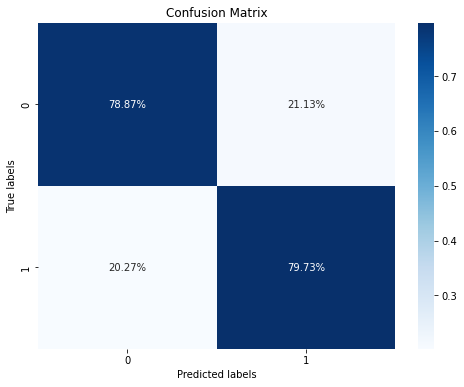

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.79      0.79    159563
    POSITIVE       0.79      0.80      0.79    160437

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [ ]:
mislabeled_examples = evaluate_model(model, test_loader, y_test, df_test["text"])

## True Validation

In [ ]:
# Load and preprocess the stock dataset
stock_dataset_path = os.path.join("", "data", dataset_filename["1"][0])
stock_df = pd.read_csv(stock_dataset_path, encoding=DATASET_ENCODING)
stock_df = stock_df.rename(columns={"Text": "text", "Sentiment": "target"})
stock_df['text'] = stock_df['text'].apply(preprocess)
x_stock = pad_sequences(tokenizer.texts_to_sequences(stock_df['text']), maxlen=SEQUENCE_LENGTH)
stock_dataset = TextDataset(x_stock, np.zeros_like(x_stock))
stock_loader = DataLoader(stock_dataset, batch_size=BATCH_SIZE, shuffle=False)
stock_df["target"] = stock_df["target"].map({-1: "NEGATIVE", 1: "POSITIVE"})
y_stock = encoder.transform(stock_df['target'].tolist()).reshape(-1, 1)


Accuracy: 0.5823
F1-Score: 0.6534
ROC-AUC: 0.5977


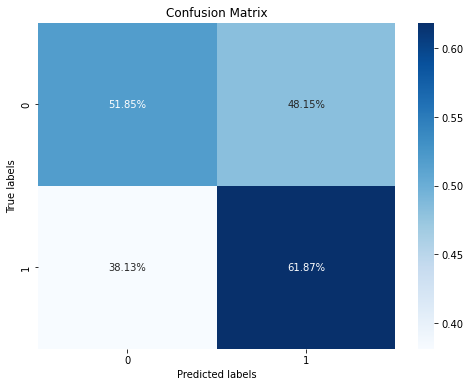

              precision    recall  f1-score   support

    NEGATIVE       0.44      0.52      0.47      2106
    POSITIVE       0.69      0.62      0.65      3685

    accuracy                           0.58      5791
   macro avg       0.56      0.57      0.56      5791
weighted avg       0.60      0.58      0.59      5791



In [ ]:
res_stock = evaluate_model(model, stock_loader, y_stock, stock_df['text'])

In [ ]:
def categorize_errors(mislabeled_examples):
    short_texts = []
    texts_with_not = []
    other_errors = []

    for example in mislabeled_examples:
        text = example["original_text"]
        if len(text.split()) < 5:  # Assuming a short text has less than 5 words
            short_texts.append(text)
        elif "not" in text:
            texts_with_not.append(text)
        else:
            other_errors.append(text)

    return short_texts, texts_with_not, other_errors

def quantify_errors(short_texts, texts_with_not, other_errors):
    print(f"Number of short texts: {len(short_texts)}")
    print(f"Number of texts with 'not': {len(texts_with_not)}")
    print(f"Number of other errors: {len(other_errors)}")

def deep_dive(short_texts, texts_with_not):
    print("\nExamples of short texts:")
    for text in short_texts[:5]:  # Print first 5 examples
        print(text)

    print("\nExamples of texts with 'not':")
    for text in texts_with_not[:5]:  # Print first 5 examples
        print(text)

# Assuming you've already gathered mislabeled examples using the evaluate_model function

mislabels = res_stock
short_texts, texts_with_not, other_errors = categorize_errors(mislabels)
quantify_errors(short_texts, texts_with_not, other_errors)
deep_dive(short_texts, texts_with_not)


Number of short texts: 316
Number of texts with 'not': 49
Number of other errors: 2054

Examples of short texts:
oi 21 37
red ready break
bac 11 97 trade
sk gave
p long 9 55

Examples of texts with 'not':
nvda love see momo next week like previous histogram bars noted
user onxx strong price vol expansion friday possibly looking higher prices another biotech 2 levels
fio bouncing morning 25 short interest still nothing air till 17 90s
anyone noticed hge volume today thing pushes 6 today might runner next week
remain convinced either apple stock aap another five years sold already middle ground


In [ ]:
def print_mislabeled_examples(mislabeled_examples):
    for i, example in enumerate(mislabeled_examples, start=1):
        print(f"Example {i}:")
        print(f"Original Text: {example['original_text']}")
        print(f"Predicted Label: {example['predicted']}")
        print(f"True Label: {example['true']}")
        print("\n")

# Example usage:
print_mislabeled_examples(res_stock)


Example 1:
Original Text: user afraid short amzn looking like near monopoly ebooks infrastructure service
Predicted Label: 0
True Label: 1


Example 2:
Original Text: oi 21 37
Predicted Label: 0
True Label: 1


Example 3:
Original Text: aap user current downtrend break otherwise short term correction med term downtrend
Predicted Label: 1
True Label: 0


Example 4:
Original Text: monday relative weakness nyx win tie tap ice int bmc aon c chk biib
Predicted Label: 1
True Label: 0


Example 5:
Original Text: assuming fcx opens tomorrow 34 25 trigger buy still much like setup
Predicted Label: 0
True Label: 1


Example 6:
Original Text: momentum coming back etfc broke ma200 resistance solid volume friday ong set
Predicted Label: 0
True Label: 1


Example 7:
Original Text: swy 30 float short breaking ouch
Predicted Label: 0
True Label: 1


Example 8:
Original Text: biof wants 4 90 comin
Predicted Label: 0
True Label: 1


Example 9:
Original Text: red ready break
Predicted Label: 1
True Label